In [1]:
pip install librosa soundfile

In [2]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio, display, HTML

def stereo_to_mono(stereo_sound):
    mono_sound = np.mean(stereo_sound, axis=1)
    return mono_sound

#Carregar arquivos de audio
sample_rate_clean, sound_data_clean = wavfile.read("voz_1.wav")
sample_rate_voice_noise, sound_data_voice_noise = wavfile.read("voz_2.wav")
sample_rate_noise, sound_data_noise = wavfile.read("voz_3.wav")

#Converter arquivos para mono
voz_1_mono = stereo_to_mono(sound_data_clean)
voz_2_mono = stereo_to_mono(sound_data_voice_noise)
voz_3_mono = stereo_to_mono(sound_data_noise)

display(HTML("<h2>Original Sound Clean</h2>"))
display(Audio(voz_1_mono, rate=sample_rate_clean))

display(HTML("<h2>Original Sound Voice and Noise</h2>"))
display(Audio(voz_2_mono, rate=sample_rate_clean))

display(HTML("<h2>Original Sound Noise</h2>"))
display(Audio(voz_3_mono, rate=sample_rate_clean))

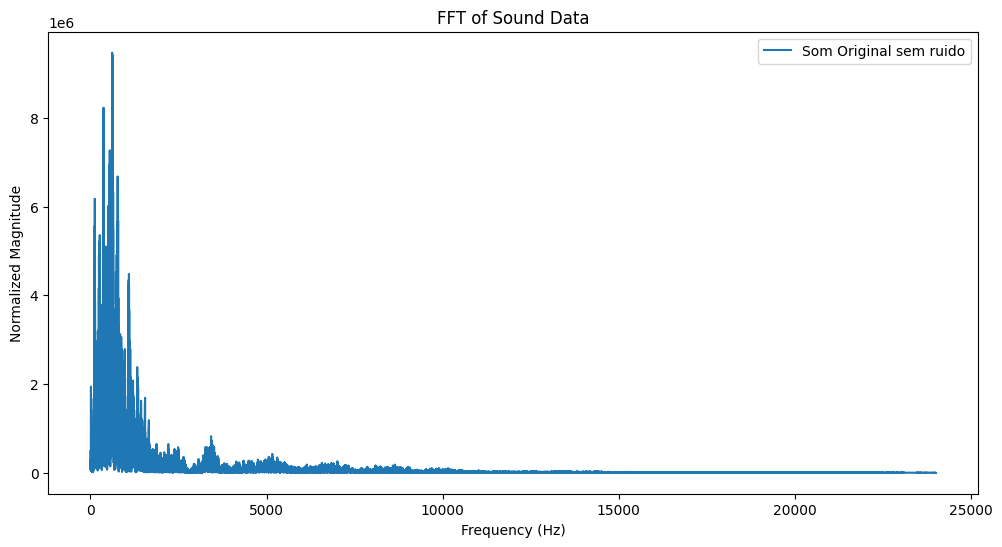

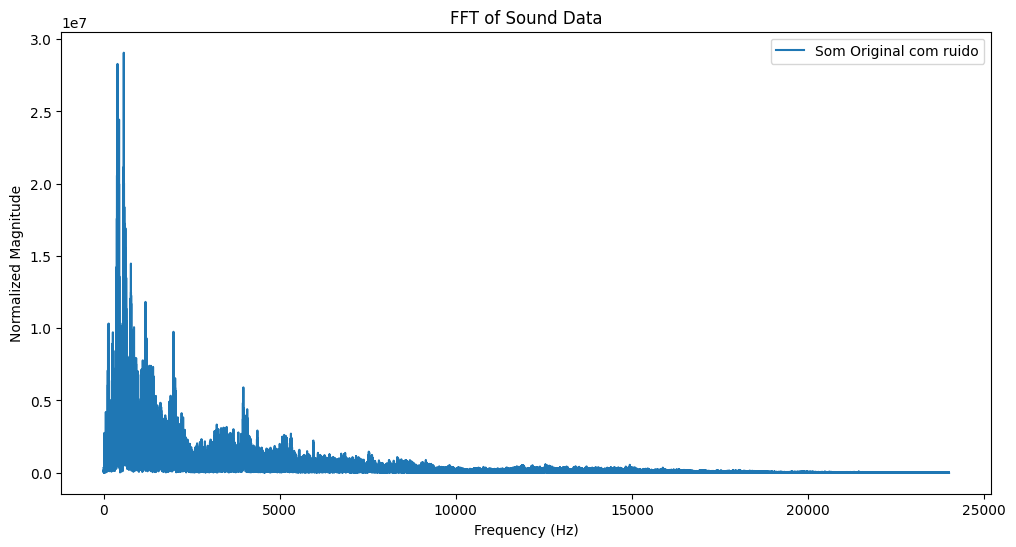

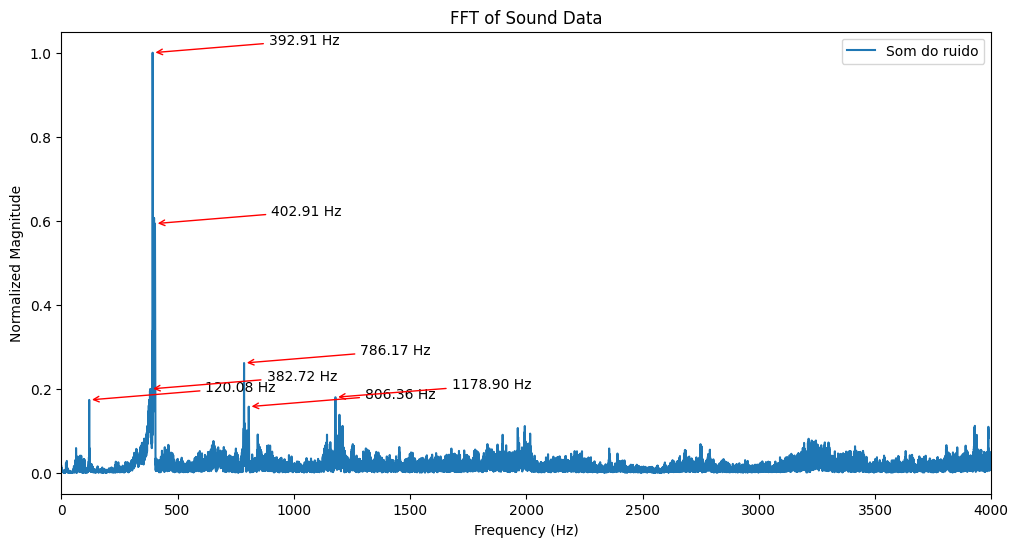

In [7]:
#Analisar FFT dos audios

#Plot fft
def plot_fft(sound_data, sample_rate, label):
    n = len(sound_data)
    freqs = np.fft.fftfreq(n, d=1/sample_rate)
    fft_result = np.fft.fft(sound_data)
    magnitude = np.abs(fft_result)
    #normalized_magnitude = magnitude / np.max(magnitude)  # Normalize the FFT magnitudes

    plt.plot(freqs[:n // 2], magnitude[:n // 2], label=label)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Magnitude")
    plt.title("FFT of Sound Data")
    plt.legend()

def plot_fft_xlim_peaks(sound_data, sample_rate, label, x_limits=None, annotate_peaks=True, peak_threshold=0.1):
    n = len(sound_data)
    freqs = np.fft.fftfreq(n, d=1/sample_rate)
    fft_result = np.fft.fft(sound_data)
    magnitude = np.abs(fft_result)
    normalized_magnitude = magnitude / np.max(magnitude)  # Normalize the FFT magnitudes

    plt.plot(freqs[:n // 2], normalized_magnitude[:n // 2], label=label)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Magnitude")
    plt.title("FFT of Sound Data")
    plt.legend()

    if x_limits is not None:
        plt.xlim(x_limits)

    if annotate_peaks:
        # Identify peak frequencies (local maxima)
        peaks, _ = scipy.signal.find_peaks(normalized_magnitude[:n // 2], distance=50)
        peak_frequencies = freqs[peaks]
        peak_magnitudes = normalized_magnitude[peaks]

        highest_peak_indices = np.where(peak_magnitudes > peak_threshold)
        highest_peak_frequencies = peak_frequencies[highest_peak_indices]
        highest_peak_magnitudes = peak_magnitudes[highest_peak_indices]

        for freq, mag in zip(highest_peak_frequencies, highest_peak_magnitudes):
            plt.annotate(f'{freq:.2f} Hz', xy=(freq, mag), xytext=(freq + 500, mag + 0.02),
                         arrowprops=dict(arrowstyle='->', color='red'))

#plot fft
plt.figure(figsize=(12, 6))
plot_fft(voz_1_mono, sample_rate_clean,"Som Original sem ruido")

plt.figure(figsize=(12, 6))
plot_fft(voz_2_mono, sample_rate_voice_noise,"Som Original com ruido")

plt.figure(figsize=(12, 6))
plot_fft_xlim_peaks(voz_3_mono, sample_rate_noise,"Som do ruido",x_limits=(0,4000),annotate_peaks=True,peak_threshold=0.15)


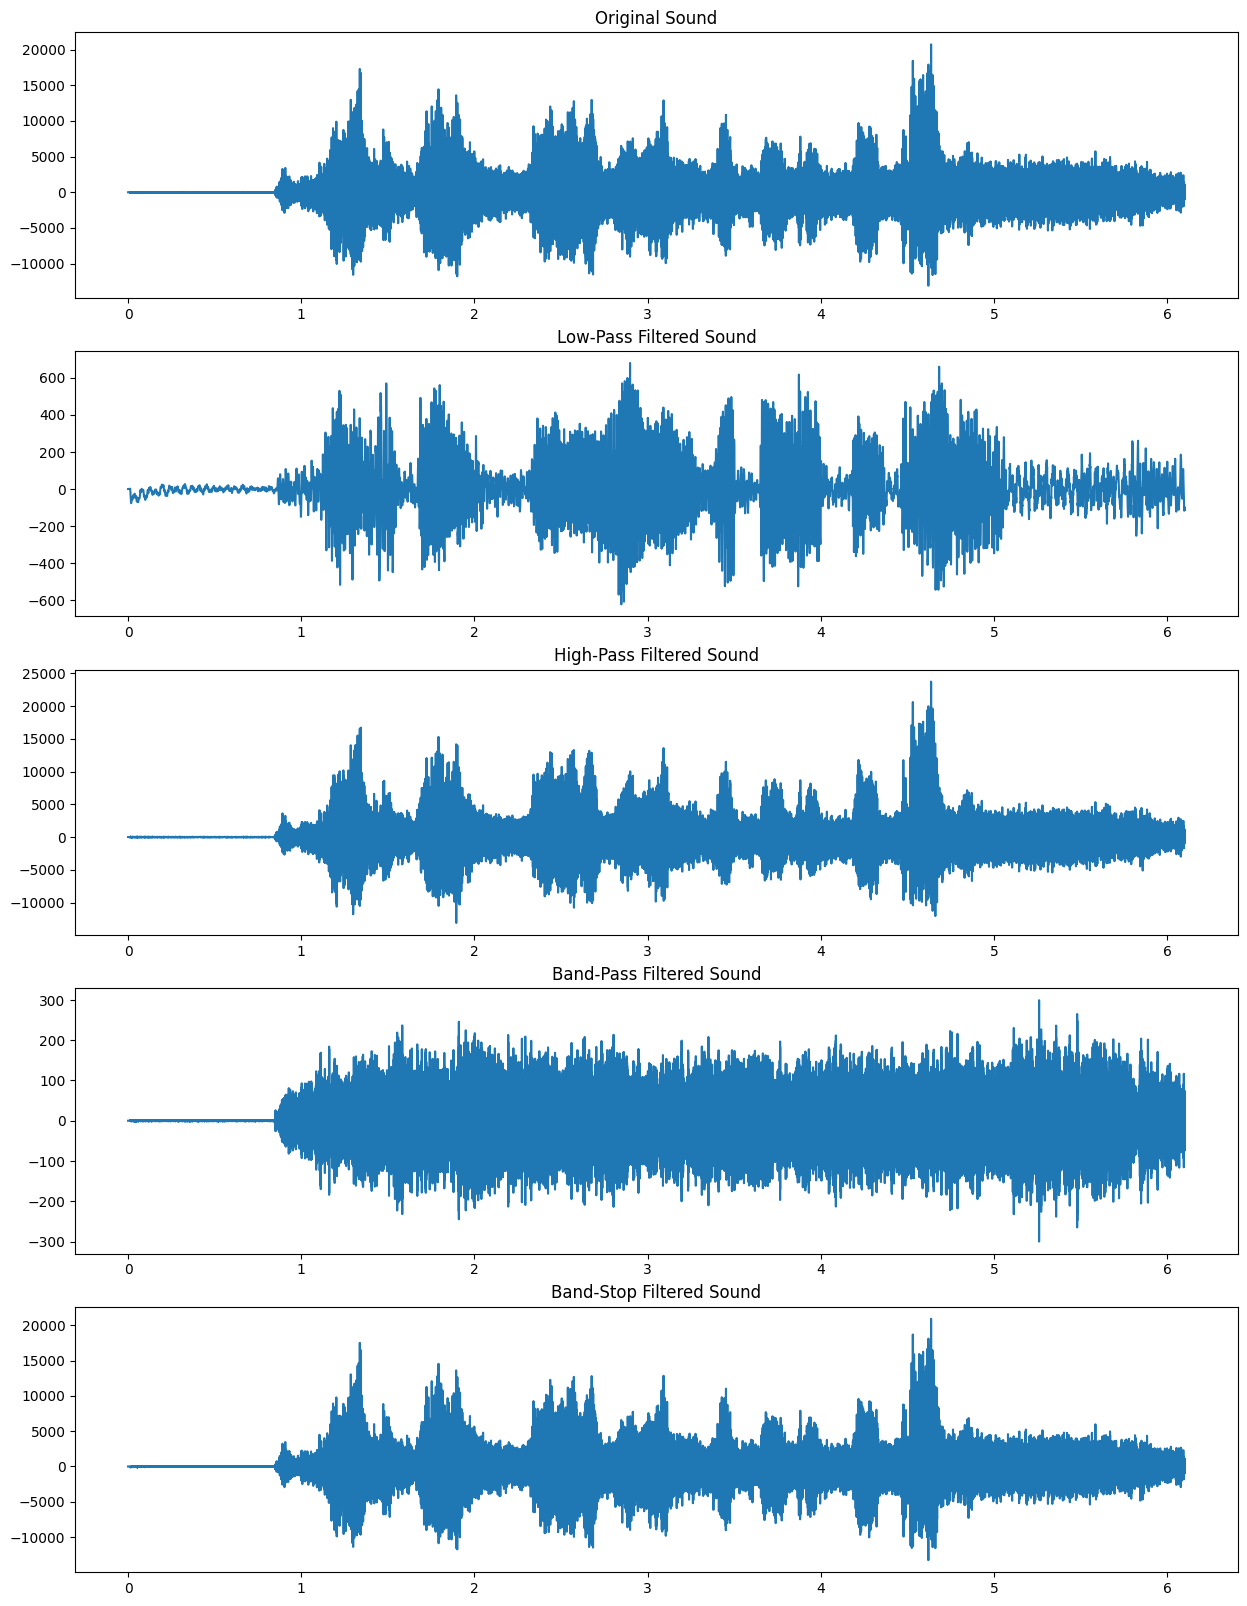

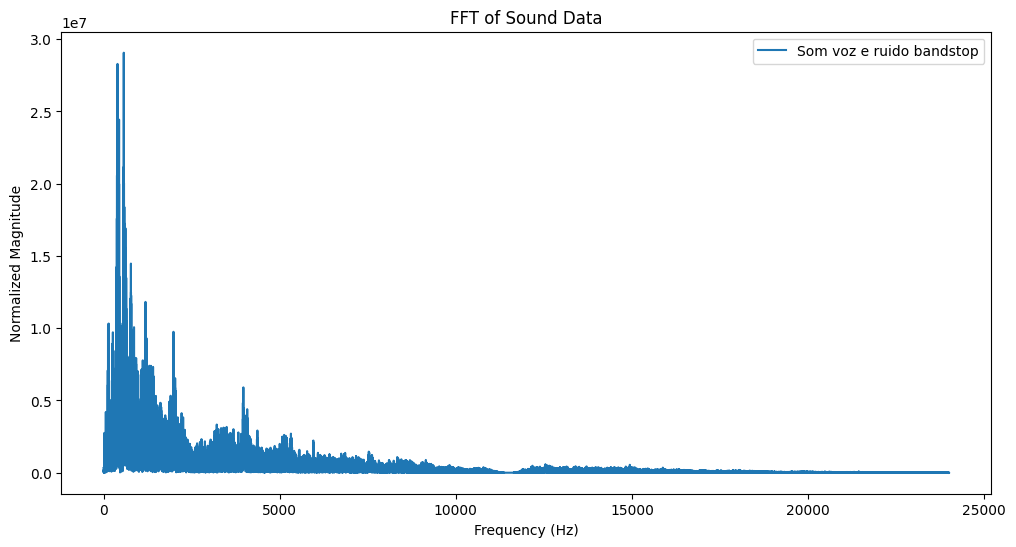

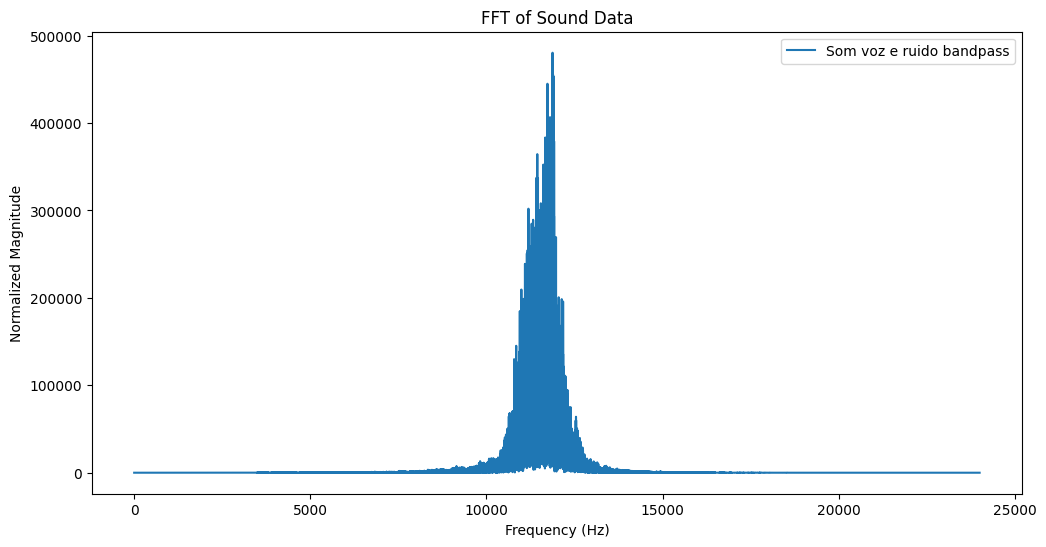

In [13]:
#Filter Design

#Define filter parameters
low_cutoff = 100
high_cutoff = 100
pass_band = [11000,12000]
stop_band = [11000,12000]
filter_order = 3

#Calculate Nyquist Frequency
nyquist_freq_clean = 0.5 * sample_rate_clean
nyquist_freq_voice_noise = 0.5 * sample_rate_voice_noise
nyquist_freq_noise = 0.5 * sample_rate_noise

# Comb filter (reverb-like effect)
delay = int(0.03 * sample_rate_voice_noise)  # Delay in samples for the comb filter
b_comb = [0.5] + [0.0] * (delay - 1) + [0.5]
filtered_comb = scipy.signal.lfilter(b_comb, [1.0], voz_2_mono)

# FIR filters
taps = 51  # Number of taps for FIR filter
b_fir = scipy.signal.firwin(taps, cutoff=0.2, window='hamming')
filtered_fir = scipy.signal.lfilter(b_fir, [1.0], voz_2_mono)

# IIR filter (Chebyshev Type I low-pass)
ripple = 2.0  # Ripple factor for Chebyshev Type I filter
b_iir, a_iir = scipy.signal.cheby1(filter_order, ripple, low_cutoff / nyquist_freq_voice_noise, btype='low')
filtered_iir = scipy.signal.lfilter(b_iir, a_iir, voz_2_mono)

#Extract coefficients for filtering
b_low, a_low = scipy.signal.butter(filter_order, low_cutoff/nyquist_freq_noise, btype='lowpass')
b_high, a_high = scipy.signal.butter(filter_order, high_cutoff/nyquist_freq_noise, btype='highpass')
b_pass, a_pass = scipy.signal.butter(filter_order, [pass_band[0] / nyquist_freq_noise, pass_band[1] / nyquist_freq_noise], btype='bandpass')
b_stop, a_stop = scipy.signal.butter(filter_order, [stop_band[0] / nyquist_freq_noise, stop_band[1] / nyquist_freq_noise], btype='bandstop')

#Aplly filters
voz_2_lowpass = scipy.signal.lfilter(b_low,a_low,voz_2_mono)
voz_2_highpass = scipy.signal.lfilter(b_high,a_high,voz_2_mono)
voz_2_pass = scipy.signal.lfilter(b_pass,a_pass,voz_2_mono)
voz_2_stop = scipy.signal.lfilter(b_stop,a_stop,voz_2_mono)

## Display and play the results
plt.figure(figsize=(15, 20))

plt.subplot(5, 1, 1)
plt.plot(np.arange(len(voz_2_mono)) / sample_rate_voice_noise, voz_2_mono)
plt.title("Original Sound")

plt.subplot(5, 1, 2)
plt.plot(np.arange(len(voz_2_lowpass)) / sample_rate_voice_noise, voz_2_lowpass)
plt.title("Low-Pass Filtered Sound")

plt.subplot(5, 1, 3)
plt.plot(np.arange(len(voz_2_highpass)) / sample_rate_voice_noise, voz_2_highpass)
plt.title("High-Pass Filtered Sound")

plt.subplot(5, 1, 4)
plt.plot(np.arange(len(voz_2_pass)) / sample_rate_voice_noise, voz_2_pass)
plt.title("Band-Pass Filtered Sound")

plt.subplot(5, 1, 5)
plt.plot(np.arange(len(voz_2_stop)) / sample_rate_voice_noise, voz_2_stop)
plt.title("Band-Stop Filtered Sound")

#Play Sounds
# Play the filtered sounds
display(HTML("<h2>Original Sound with Noise</h2>"))
display(Audio(voz_2_mono, rate=sample_rate_voice_noise))

display(HTML("<h2>Low Pass Filter</h2>"))
display(Audio(voz_2_lowpass, rate=sample_rate_voice_noise))

display(HTML("<h2>High Pass Filter</h2>"))
display(Audio(voz_2_highpass, rate=sample_rate_voice_noise))

display(HTML("<h2>Band Pass Filter</h2>"))
display(Audio(voz_2_pass, rate=sample_rate_voice_noise))

display(HTML("<h2>Band Stop Filter</h2>"))
display(Audio(voz_2_stop, rate=sample_rate_voice_noise))

#plot fft
plt.figure(figsize=(12, 6))
plot_fft(voz_2_stop, sample_rate_clean,"Som voz e ruido bandstop")

#plot fft
plt.figure(figsize=(12, 6))
plot_fft(voz_2_pass, sample_rate_clean,"Som voz e ruido bandpass")
